In [1]:
import glob
import json


import geopandas as gpd
import matplotlib
%matplotlib inline
import pandas as pd
import numpy as np

from datetime import datetime


In [2]:

def process_json(fname):
    with open(fname) as f:
        data = json.load(f)
        if set(data.keys()) != set(['BusPositions']):
            raise Exception("Other keys? {}".format(set(data.keys())))
        return data['BusPositions']
    
def load_day(day):
    df = pd.concat((pd.DataFrame(process_json(x)) for x in  glob.glob(day +"/*")), ignore_index=True)
    garr = gpd.vectorized.points_from_xy(df["Lon"].as_matrix(), df["Lat"].as_matrix())
    df["geometry"] = garr
    gdf = gpd.GeoDataFrame(df)
    gdf.crs = {'init' :'epsg:4326'}
    gdf = gdf.to_crs(epsg=3857)
    gdf["dt"] = pd.to_datetime(gdf["DateTime"])
    return gdf

gtfs_trips = pd.read_csv("data/gtfs/trips.txt", dtype={'trip_id': str, 'scheduled_trip_id': str})
gtfs_schedule = pd.read_csv("data/gtfs/stop_times.txt", dtype={'trip_id': str})
gtfs_cal = pd.read_csv("data/gtfs/calendar_dates.txt")

In [ ]:
import contextily as ctx

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

In [ ]:
ax = gpd.GeoSeries([gdf.geometry.unary_union.convex_hull]).plot(alpha=.2)
add_basemap(ax, 10)

In [ ]:
gdf["dt"] = pd.to_datetime(gdf["DateTime"])
gdf = gdf.sort_values("dt")
gdf.head()

### Filter to 1 line only (S4)

In [ ]:
s4_only = gdf[gdf["RouteID"] == "S4"]
len(s4_only), s4_only.TripID.nunique()

### Look at distribution of # of reports

In [ ]:
s4_only.TripID.value_counts().hist(figsize=(16, 9))

### Pick one that's on the far right

In [ ]:
vcs = s4_only.TripID.value_counts()
s4_only[s4_only.TripID.isin(vcs[vcs > 115].index)].TripID.unique()

In [ ]:
pd.options.display.max_rows = 200
INTERESTING_TRIP = '944128020'
interesting_id = s4_only[s4_only.TripID == INTERESTING_TRIP].sort_values('dt')
interesting_id

### Hmm
looks like this is 2 separate trips, given the hour break between reporting from 9:06 to 10:07

In [ ]:
cut_wwtime =  datetime(2019, 4, 1, 12, 0)

color = [('red' if x <= cut_time else 'blue') for x in interesting_id['dt']]

interesting_id[interesting_id.dt < cut_time].plot()

In [ ]:
import numpy as np
alphas = (interesting_id[interesting_id.dt > cut_time].dt -\
          interesting_id[interesting_id.dt > cut_time].dt.min()).dt.total_seconds()
alphas = alphas / alphas.max()
rgba_colors = np.zeros((len(alphas),4))
rgba_colors[:, 0] = 1
rgba_colors[:, 3] = alphas
ax = interesting_id[interesting_id.dt > cut_time].plot(color=rgba_colors, figsize=(16, 9))
#interesting_id[interesting_id.dt < cut_time].plot(alpha=.2, color='blue', ax=ax)
add_basemap(ax, zoom=10)


In [ ]:
(interesting_id.dt < cut_time).sum(), (~(interesting_id.dt < cut_time)).sum()

In [ ]:
gtfs_trips[gtfs_trips['scheduled_trip_id'] == INTERESTING_TRIP]

In [ ]:
unique_trips = set(s4_only.TripID.unique())
unique_in_gtfs = set(gtfs_trips['scheduled_trip_id'])
len(unique_trips), len(unique_trips - unique_in_gtfs), len(unique_trips)- len(unique_trips - unique_in_gtfs)

In [ ]:
diff = unique_trips - unique_in_gtfs

In [ ]:
s4_only.TripID.value_counts().hist()
s4_only[s4_only.TripID.isin(diff)].TripID.value_counts().hist(color='red')

In [ ]:
ax = s4_only[~s4_only.TripID.isin(diff)].plot()
ax = s4_only[s4_only.TripID.isin(diff)].plot(color='red', alpha=.1, ax=ax)
MIN = s4_only.geometry.x.min()
s4_only[s4_only.geometry.x == MIN].plot(ax=ax, color='yellow')

### Generalize the above

In [ ]:
service_ids_today = gtfs_cal[gtfs_cal.date == 20190401].service_id.unique()
all_s4_trips = gtfs_trips[gtfs_trips.route_id == "S4"]
all_s4_trips_today = all_s4_trips[all_s4_trips.service_id.isin(service_ids_today)]
len(all_s4_trips), len(all_s4_trips_today)

In [ ]:
service_ids_today = gtfs_cal[gtfs_cal.date == 20190401].service_id.unique()
trips_today = gtfs_trips[gtfs_trips.service_id.isin(service_ids_today)]
route_ids = trips_today.route_id.unique()

def pct_present(route_today):
    route_id = route_today.RouteID.iloc[0]
    unique_trips_today = set(route_today.TripID.unique())
    unique_trips_scheduled = set(trips_today[trips_today.route_id == route_id].scheduled_trip_id.unique())
    scheduled_and_reported = unique_trips_today.intersection(unique_trips_scheduled)
    return pd.Series((len(unique_trips_today), len(unique_trips_scheduled),
          len(scheduled_and_reported) / (len(unique_trips_scheduled) if len(unique_trips_scheduled) > 0 else 999999)* 100))
pct_present_report = df.groupby("RouteID").apply(pct_present)
pct_present_report.columns = ["n_reported_today", "n_in_schedule", "pct_present"]

In [ ]:
pct_present_report.pct_present.hist(figsize=(16, 9))

In [ ]:
pct_present_report["bayes"] = (pct_present_report["pct_present"] * pct_present_report["n_in_schedule"] + 7) /\
                              (pct_present_report["n_in_schedule"] + 10)

In [ ]:
pct_present_report.bayes.hist(figsize=(16, 9))

In [ ]:
pd.options.display.max_rows = 250
pct_present_report.sort_values("pct_present")


## Now generalize that


In [4]:
service_ids_today = gtfs_cal[gtfs_cal.date == 20190401].service_id.unique()
all_s4_trips = gtfs_trips[gtfs_trips.route_id == "S4"]
all_s4_trips_today = all_s4_trips[all_s4_trips.service_id.isin(service_ids_today)]
len(all_s4_trips), len(all_s4_trips_today)


gtfs_cal["datetime"] = pd.to_datetime(gtfs_cal["date"], format="%Y%m%d")
gtfs_cal.head()
days[0].split("/")[1]

'2019-02-28'

In [5]:
days = sorted([d for d in glob.glob("data/*") if 'tar' not in d and 'gtfs' not in d])

def pct_present(route_today):
    route_id = route_today.RouteID.iloc[0]
    unique_trips_today = set(route_today.TripID.unique())
    unique_trips_scheduled = set(trips_today[trips_today.route_id == route_id].scheduled_trip_id.unique())
    scheduled_and_reported = unique_trips_today.intersection(unique_trips_scheduled)
    return pd.Series((len(unique_trips_today), len(unique_trips_scheduled),
          len(scheduled_and_reported) / (len(unique_trips_scheduled) if len(unique_trips_scheduled) > 0 else 999999)* 100))

results = []
for day in days:
    date = datetime.strptime(day.split("/")[1], "%Y-%m-%d")
    if date < datetime(2019, 4, 1):
        continue
    service_ids_today = gtfs_cal[gtfs_cal.datetime == date].service_id.unique()
    print(date, len(service_ids_today))
    gdf = load_day(day)
    trips_today = gtfs_trips[gtfs_trips.service_id.isin(service_ids_today)]
    route_ids = trips_today.route_id.unique()

    pct_present_report = gdf.groupby("RouteID").apply(pct_present)
    pct_present_report.columns = ["n_reported_today", "n_in_schedule", "pct_present"]
    results.append((date, pct_present_report))

2019-04-01 00:00:00 9
I am densified (external_values, 655304 elements)
2019-04-02 00:00:00 9
I am densified (external_values, 687628 elements)
2019-04-03 00:00:00 9
I am densified (external_values, 688905 elements)
2019-04-04 00:00:00 8
I am densified (external_values, 682159 elements)
2019-04-05 00:00:00 7
I am densified (external_values, 683255 elements)
2019-04-06 00:00:00 2
I am densified (external_values, 399087 elements)
2019-04-07 00:00:00 3
I am densified (external_values, 322626 elements)
2019-04-08 00:00:00 9
I am densified (external_values, 652445 elements)
2019-04-09 00:00:00 9
I am densified (external_values, 691378 elements)
2019-04-10 00:00:00 9
I am densified (external_values, 691839 elements)
2019-04-11 00:00:00 9
I am densified (external_values, 689653 elements)
2019-04-12 00:00:00 8
I am densified (external_values, 689556 elements)
2019-04-13 00:00:00 2
I am densified (external_values, 398586 elements)
2019-04-14 00:00:00 3
I am densified (external_values, 324581 el

In [6]:
def process_result(result):
    date, df = result
    df["date"] = date
    return df.reset_index()
results_df = pd.concat((process_result(result) for result in results), ignore_index=True)

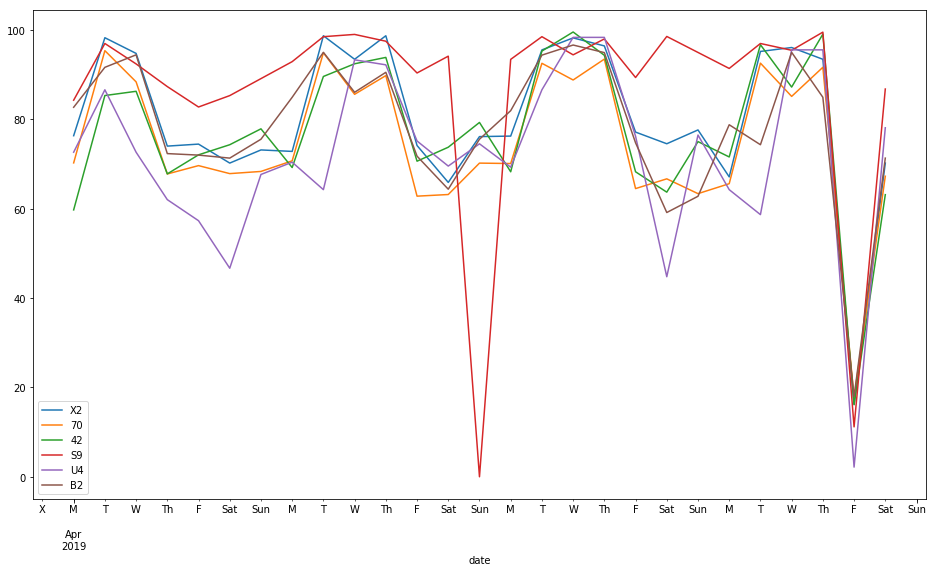

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(16, 9))

big_trips = results_df.sort_values("n_in_schedule", ascending=False).iloc[:100]
for routeid in big_trips.RouteID.unique():
    route_info = results_df[results_df["RouteID"] == routeid]
    route_info.set_index('date').pct_present.plot(ax=ax, label=routeid)
    ax.legend()
q = ax.set_xticklabels(['X', 'X'] + ['M', 'T', 'W', 'Th', 'F', 'Sat', 'Sun'] * 4, minor=True)